# Loading modules

In [1]:
# Import necessary modules
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# Functions for parsing, formatting and encoding data

In [2]:
def parse_pssm(pssm_filename):
  amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
  num_aas = len(amino_acids)
  sequence = ''
  profile = []

  # Parsing MSA frequences from a PSSM file 
  with open(pssm_filename) as pssm:
    pssm_lines = pssm.readlines()
    for line in pssm_lines[3:-6]:                 # First iterates over lines
      profile_line = []
      for n in line.rstrip().split()[22:-2]:      # Then over n in line 
        profile_line.append(float(n)/100)         # Converts the values to a scale of 0 to 1
      profile.append(profile_line)
      sequence += line[6]                         # Fetches the protein sequence: every 6th character in given line n

  # One-hot encoding the protein sequence
  encoding = np.zeros((len(sequence), num_aas))   # Initialises a 2D array of zeros
  for i, aa in enumerate(sequence):               # Returns an iterator that produces tuples containing both the index and aa
    if aa in amino_acids:
      index = amino_acids.index(aa)               # Finds corresponding index in aa string 
      encoding[i, index] = 1                      # 0 is replaced with 1 in the array, at position: seq index x aa string index
    else: encoding[i, :] = 0.05                   # If aa not found in file, fill the entire row with 0.05 to represent unknown/invalid aa

  return encoding, profile


# Parsing the DSSP labels
def parse_dssp(dssp_filename):
	ss = ''
	with open(dssp_filename) as dssp:
		dssp.readline()
		ss = dssp.readline().rstrip()
	return ss

# Function for fetching appropriate data

In [3]:
def fetch_data(window, cv=False, train=True):
  ss_map = {'H':[1,0,0], 'E':[0,1,0], 'C':[0,0,1], '-':[0,0,1]}

  # Make sure that window is an odd integer
  assert type(window) == int, 'Error: window must be an integer!'
  assert window%2!=0, 'Error: window must be an ODD integer!'


  # Selecting which data to fetch (training or blind test) and loading the right list of ids
  if not cv:
    path = 'C:/Users/liisa/OneDrive/Dokumendid/ROOTSI/SU/Bioinformatics/Project/protein-ss-pred-master/data/blindTest/'
    id_list = [line.rstrip() for line in open(path+'list.txt')]
    print ('Test data is obtained:')
  else:
    cv = str(cv)
    path = 'C:/Users/liisa/OneDrive/Dokumendid/ROOTSI/SU/Bioinformatics/Project/protein-ss-pred-master/data/training/'
    if train:
      id_list = [line.rstrip() for line in open(path+'/cv/train'+cv+'.txt')]           # Using list comprehension to store train set id-s
      print ('Train partition of cross-validation set {} is obtained:'.format(cv))
    else:
      id_list = [line.rstrip() for line in open(path+'/cv/test'+cv+'.txt')]
      print ('Test partition of cross-validation set {} is obtained:'.format(cv))

  X, Y = [], []
  for id in id_list:
    # Fetching the input features
    id = id.replace(":", "_")
    sequence, profile = np.array(parse_pssm(path+'/pssm/'+id+'.pssm'))                 # sequence = one-hot encoded sequence
    x = np.concatenate((sequence, profile), axis=-1)                        
 
    # Fetching, encoding labels, storing in array y
    ss = parse_dssp(path+'/dssp/'+id+'.dssp')
    y = np.array([ss_map[c] for c in ss])

    # Adding (window-1)/2 padding on both sequence sides
    # Creating windows for first and last positions
    side = int((window-1)/2)
    x_pad = np.zeros((side, 40))
    x = np.concatenate((x_pad, x, x_pad), axis=0)

    # Extracting all windows:
    # For each index i in the range from side to len(x)-side-1, it creates a window centered at position i
    # Each window is extracted as a subarray of x from index i-side to i+side+1
    X += [x[i-side:i+side+1,:] for i in range(side, len(x)-side-1)]                   
    Y += [y[i,:] for i in range(len(y))]                                              # Corresponding labels for Y
    X.append(x[-2*side-1:,:])                                                         # Extracts a window of size 2*side+1 from beginning of sequence and appends to X

  return np.array(X), np.array(Y)

# Declaring a neural network

In [4]:
window = 17
input_shape = (window, 40)
num_classes = 3

model = keras.Sequential([
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation="leaky_relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="leaky_relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

model.summary() 
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 680)               0         
                                                                 
 dense (Dense)               (None, 256)               174336    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                      

# Fetching data and training the model

In [5]:
models = []
train_accuracies = []
val_accuracies = []

for fold in range(1, 6):
    # Loading training and testing data for the current fold
    x_train, y_train = fetch_data(window, cv=fold, train=True)
    print(x_train.shape, y_train.shape)
    x_test, y_test = fetch_data(window, cv=fold, train=False)
    print(x_test.shape, y_test.shape)

    # Training model on the training data
    history = model.fit(x_train, y_train, epochs=10, batch_size=512, validation_split=0.1)
    
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Evaluating model on the testing data
    loss, accuracy = model.evaluate(x_test, y_test)
    models.append(model)
    
    print("Fold {0}: Loss = {1}, Accuracy = {2}".format(fold, round(loss,2), round(accuracy,2)))

Train partition of cross-validation set 1 is obtained:
(157415, 17, 40) (157415, 3)
Test partition of cross-validation set 1 is obtained:
(40729, 17, 40) (40729, 3)
Epoch 1/10


277/277 [==============================] - 4s 9ms/step - loss: 0.9808 - accuracy: 0.5592 - val_loss: 0.7208 - val_accuracy: 0.6999
Epoch 2/10
277/277 [==============================] - 2s 8ms/step - loss: 0.7611 - accuracy: 0.6810 - val_loss: 0.6671 - val_accuracy: 0.7252
Epoch 3/10
277/277 [==============================] - 2s 8ms/step - loss: 0.7276 - accuracy: 0.6994 - val_loss: 0.6551 - val_accuracy: 0.7323
Epoch 4/10
277/277 [==============================] - 2s 9ms/step - loss: 0.7044 - accuracy: 0.7114 - val_loss: 0.6370 - val_accuracy: 0.7400
Epoch 5/10
277/277 [==============================] - 2s 8ms/step - loss: 0.6809 - accuracy: 0.7223 - val_loss: 0.6148 - val_accuracy: 0.7501
Epoch 6/10
277/277 [==============================] - 2s 8ms/step - loss: 0.6581 - accuracy: 0.7316 - val_loss: 0.5980 - va

# Plotting the best model's accuracy

c:\Users\liisa\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


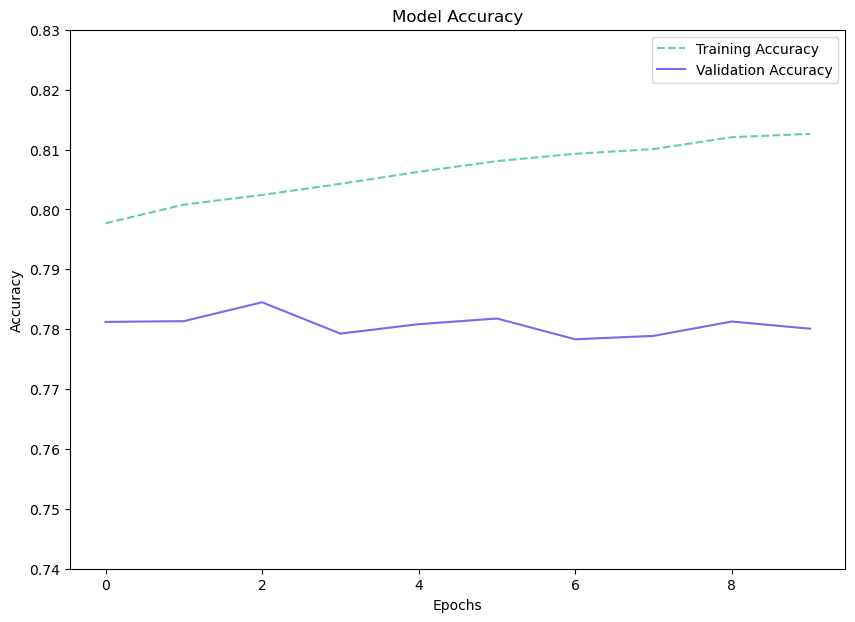

In [6]:
trained_model = models[4]
trained_model.save('C:/Users/liisa/OneDrive/Dokumendid/ROOTSI/SU/Bioinformatics/Project/trained_FCNN.h5')

plt.figure(figsize=(10, 7))
plt.plot(train_accuracies[4], label="Training Accuracy", linestyle='--', color="mediumaquamarine")
plt.plot(val_accuracies[4], label="Validation Accuracy", color="mediumslateblue")
plt.ylim(0.74, 0.83)

plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Fetching blind test data, using fitted model to get predictions, and evaluating prediction metrics

In [7]:
x_blind_test, y_blind_test = fetch_data(window, cv=False, train=False)
print(x_blind_test.shape, y_blind_test.shape)

Test data is obtained:
(62136, 17, 40) (62136, 3)


In [8]:
predictions = trained_model.predict(x_blind_test)

# Reporting model's accuracy
print("Accuracy: ", round(accuracy_score(np.argmax(y_blind_test, axis=1), np.argmax(predictions, axis=1)),2))

# Converting one-hot encoded labels back to categorical labels
y_blind_test_cat = np.argmax(y_blind_test, axis=1)
predictions_cat = np.argmax(predictions, axis=1)

# Calculating F1 score for each class
F1_scores = f1_score(y_blind_test_cat, predictions_cat, average=None)

ss_labels = ['H', 'E', 'C']
# F1 scores for each ss type
for label, score in zip(ss_labels, F1_scores):
    print("Secondary Structure: {0}, F1-score = {1}".format(label,round(score,2)))

1942/1942 [==============================] - 2s 1ms/step
Accuracy:  0.75
Secondary Structure: H, F1-score = 0.79
Secondary Structure: E, F1-score = 0.7
Secondary Structure: C, F1-score = 0.74
